# Acquisition des données

In [1]:
import json
import random
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

from sklearn import preprocessing, model_selection
from sklearn import metrics

distrib = pd.read_json('Train_Intensite_H.json')
distrib['Intensite'] = distrib['Intensite'].apply(lambda x: np.array(x)/(np.array(x).max())).tolist()

2023-12-03 17:35:40.590264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# SPLIT AND SLICING

In [2]:
# Acquisition
df_train = pd.read_json('Train_Intensite_H.json')
df_train['Intensite'] = df_train['Intensite'].apply(lambda x: np.array(x)/(np.array(x).max())).tolist()
df_test = pd.read_json('Test_Intensite_H.json')
df_test['Intensite'] = df_test['Intensite'].apply(lambda x: np.array(x)/(np.array(x).max())).tolist()

#Preprocessing
scaler = preprocessing.MinMaxScaler()
x_train_list = [ scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in df_train['Intensite']]
y_train_list = [i for i in df_train['Diagnostic']]
x_test_list = [ scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in df_test['Intensite']]
y_test_list = [i for i in df_test['Diagnostic']]

#Création des jeu d'entrainement, de validation et de Test
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_list, y_train_list, test_size=0.2, random_state=42, shuffle=True)
x_train = np.asarray(x_train).astype(np.float32).reshape(-1, 256, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
x_val = np.asarray(x_val).astype(np.float32).reshape(-1, 256, 1)
y_val = np.asarray(y_val).astype(np.float32).reshape(-1, 1)
x_test = np.asarray(x_test_list).astype(np.float32).reshape(-1, 256, 1)
y_test = np.asarray(y_test_list).astype(np.float32).reshape(-1, 1)

Affichage d'un profil pour verification

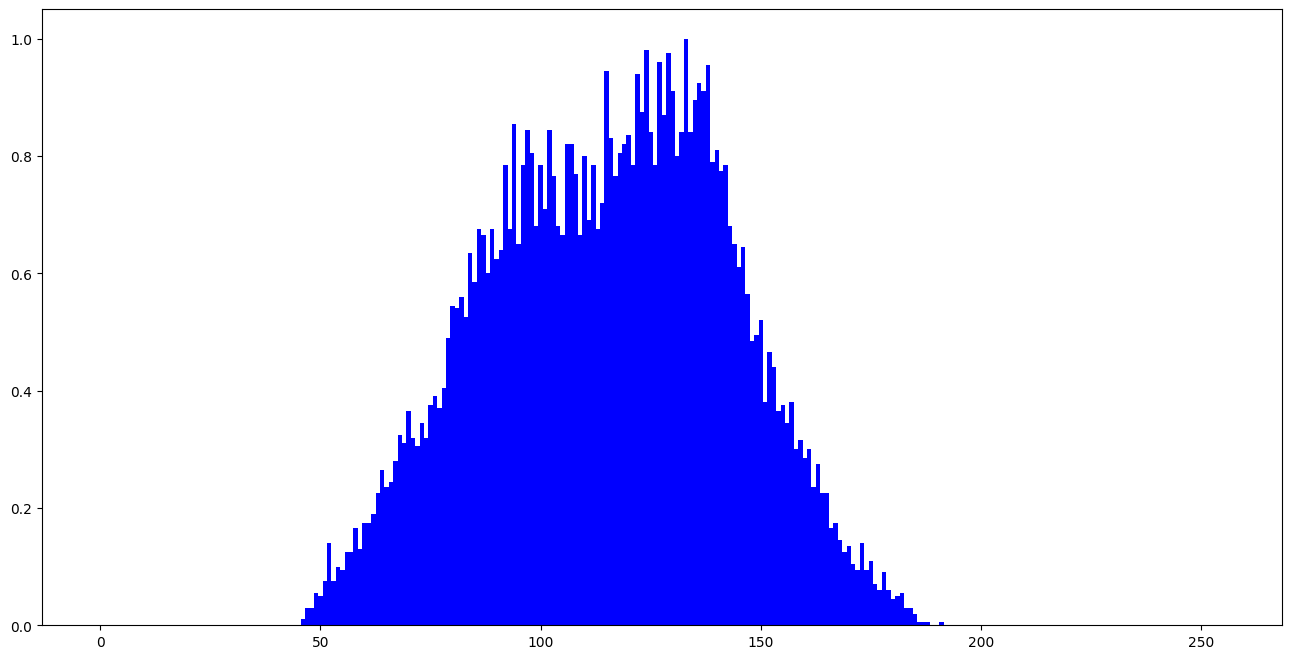

In [25]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(111)
ax1.bar(range(256),x_val[150].reshape(256), color = 'blue', width = 1);



### Define simple function to plot all the metrics present in a keras.callbacks.History

In [3]:
  
def plot_history_metrics(history: keras.callbacks.History):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)

    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_title('Training and Validation Accuracy')

    ax2 = fig.add_subplot(122)
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_title('Training and Validation Loss')
    plt.show()
    
    fig.savefig("Training and Validation.png")
    plt.close(fig)
    

### Define function to generate Convolutional model

In [4]:
def build_model():
    input_layer = keras.Input(shape=(256, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(8, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
    output_layer = layers.Dense(1, activation="relu")(x)
    


    return keras.Model(inputs=input_layer, outputs=output_layer)

### Define callbacks, optimizer, loss and metrics

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=2,
        min_lr=0.000001
    )]
loss = keras.losses.BinaryCrossentropy()

THRESHOLD = [0.5 ,0.4]
EPOCHS = [128, 128]
BATCH_SIZE = [128 for i in range(2)]
L_RATE = [0.001 for i in range(2)]
OPTIMIZER = [keras.optimizers.Adam(learning_rate= L_RATE[i]) for i in range(2)]

METRIC = [keras.metrics.BinaryAccuracy(name ='accuracy', threshold= THRESHOLD[i]) for i in range(2)]

### Compile model and call model.fit()

Registered model '1D Le Net' already exists. Creating a new version of this model...
Created version '6' of model '1D Le Net'.


Epoch 1/128
33/33 [==============================] - 7s 89ms/step - loss: 10.8871 - accuracy: 0.6086 - val_loss: 7.3745 - val_accuracy: 0.4995
Epoch 2/128
33/33 [==============================] - 2s 71ms/step - loss: 10.2263 - accuracy: 0.6357 - val_loss: 6.7928 - val_accuracy: 0.5266
Epoch 3/128
33/33 [==============================] - 2s 67ms/step - loss: 8.6159 - accuracy: 0.5989 - val_loss: 7.0042 - val_accuracy: 0.4937
Epoch 4/128
33/33 [==============================] - 2s 71ms/step - loss: 7.3250 - accuracy: 0.5694 - val_loss: 6.5909 - val_accuracy: 0.4937
Epoch 5/128
33/33 [==============================] - 3s 77ms/step - loss: 6.2429 - accuracy: 0.6163 - val_loss: 6.1653 - val_accuracy: 0.4937
Epoch 6/128
33/33 [==============================] - 3s 83ms/step - loss: 5.7020 - accuracy: 0.6565 - val_loss: 5.7413 - val_accuracy: 0.4937
Epoch 7/128
33/33 [==============================] - 3s 83ms/step - loss: 5.4078 - accuracy: 0.6870 - val_loss: 5.3460 - val_accuracy: 0.4937
Epoc

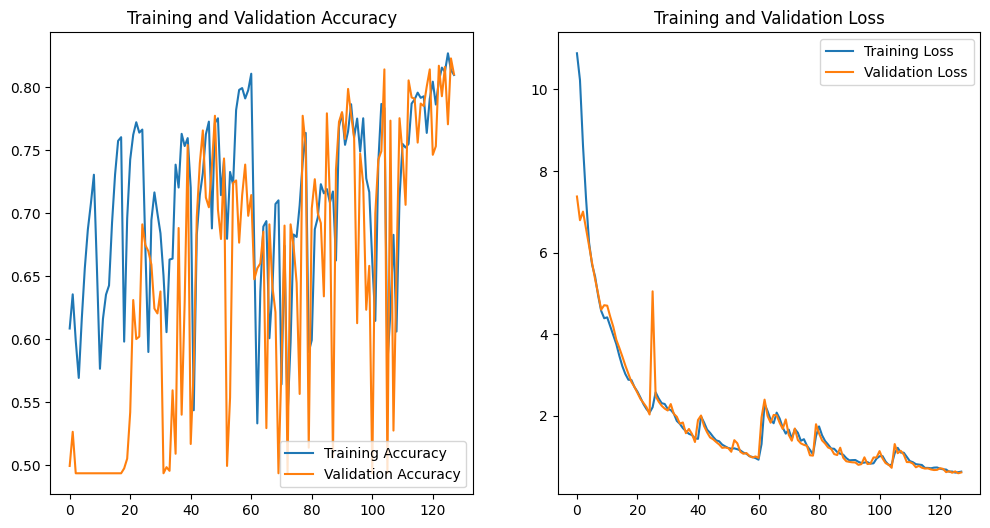

Justesse du jeu de test = 82.4 %
Sensibilité = 85.13 %
Spécificité = 79.68 %
---------Matrice de confusition-----------------
               pred:Malade     pred:Normal
vrai Malade:       687              120
vrai Normal        164              643
162/162 [==============================] - 1s 6ms/step
INFO:tensorflow:Assets written to: /var/folders/8r/qlzxp2kd2291b2t4cmprd2cw0000gn/T/tmp3n1j_5qh/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/8r/qlzxp2kd2291b2t4cmprd2cw0000gn/T/tmp3n1j_5qh/model/data/model/assets
Registered model '1D Le Net-like Binary' already exists. Creating a new version of this model...
Created version '5' of model '1D Le Net-like Binary'.
Registered model '1D Le Net' already exists. Creating a new version of this model...
Created version '7' of model '1D Le Net'.


Epoch 1/128
33/33 [==============================] - 7s 88ms/step - loss: 11.6829 - accuracy: 0.6030 - val_loss: 8.9444 - val_accuracy: 0.5015
Epoch 2/128
33/33 [==============================] - 3s 78ms/step - loss: 11.0016 - accuracy: 0.6529 - val_loss: 9.2083 - val_accuracy: 0.5382
Epoch 3/128
33/33 [==============================] - 3s 79ms/step - loss: 10.3667 - accuracy: 0.6475 - val_loss: 9.3467 - val_accuracy: 0.6834
Epoch 4/128
33/33 [==============================] - 3s 82ms/step - loss: 9.8451 - accuracy: 0.6483 - val_loss: 12.5724 - val_accuracy: 0.4937
Epoch 5/128
33/33 [==============================] - 3s 79ms/step - loss: 8.8227 - accuracy: 0.6291 - val_loss: 7.5862 - val_accuracy: 0.4937
Epoch 6/128
33/33 [==============================] - 3s 87ms/step - loss: 8.1549 - accuracy: 0.6504 - val_loss: 9.6057 - val_accuracy: 0.4937
Epoch 7/128
33/33 [==============================] - 3s 87ms/step - loss: 6.4718 - accuracy: 0.5326 - val_loss: 5.3646 - val_accuracy: 0.4937
Ep

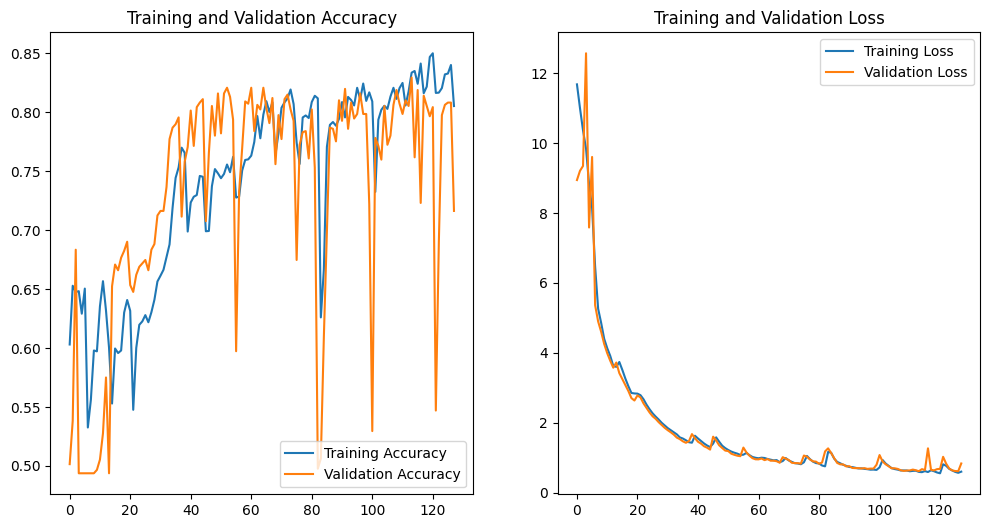

Justesse du jeu de test = 73.48 %
Sensibilité = 90.58 %
Spécificité = 56.38 %
---------Matrice de confusition-----------------
               pred:Malade     pred:Normal
vrai Malade:       731              76
vrai Normal        352              455
162/162 [==============================] - 1s 7ms/step
INFO:tensorflow:Assets written to: /var/folders/8r/qlzxp2kd2291b2t4cmprd2cw0000gn/T/tmpcurkt49c/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/8r/qlzxp2kd2291b2t4cmprd2cw0000gn/T/tmpcurkt49c/model/data/model/assets
Registered model '1D Le Net-like Binary' already exists. Creating a new version of this model...
Created version '6' of model '1D Le Net-like Binary'.


In [6]:
# Importer MLflow
import mlflow
import mlflow.keras

y_test_class = y_test.argmax(axis = 1) 
try:
    experiment_id = mlflow.create_experiment('Input Profil  ouput: Binary Malade/Normal')
except:
    experiment_name = 'Input Profil  ouput: Binary Malade/Normal'
    current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
    experiment_id=current_experiment['experiment_id']


for batch, epoch, optim, l_rate, metric, seuil  in zip(BATCH_SIZE,EPOCHS,OPTIMIZER, L_RATE, METRIC, THRESHOLD):
    with mlflow.start_run(experiment_id =experiment_id) as run:

        model_uri = f"runs:/{run.info.run_id}/keras-model"
        mv = mlflow.register_model(model_uri, "1D Le Net")

        conv_model = build_model() 
        keras.utils.plot_model(conv_model,to_file="Model.png", show_shapes=True)
        conv_model.compile( optimizer=optim,
                           loss=loss, metrics=metric)    
        conv_model_history = conv_model.fit(x_train, y_train, 
                                            validation_split = 0.2, epochs = epoch, 
                                            batch_size = batch, verbose = 1)
        
        y_pred = conv_model.predict(x_test)
        y_pred_class = np.apply_along_axis(lambda x: 1 if x>seuil else 0, 1, y_pred)

        
        confusion_m = metrics.confusion_matrix(y_test, y_pred_class)
                
        VN = confusion_m[0,0]
        VP = confusion_m[1,1]
        FN = confusion_m[1,0]
        FP = confusion_m[0,1]
                        

        plot_history_metrics(conv_model_history)
        
        print('Justesse du jeu de test =', np.round((VP+VN)/(VP+VN+FP+FN)*100,2),'%')
        print('Sensibilité =', np.round(VP*100/(VP+FN),2),'%')
        print('Spécificité =', np.round(VN*100/(VN+FP),2),'%')

        print('---------Matrice de confusition-----------------')
        print('               pred:Malade     pred:Normal')
        print('vrai Malade:      ',VP,'            ',FN)
        print('vrai Normal       ',FP,'            ',VN)
        
        signature = mlflow.models.infer_signature(x_train, conv_model.predict(x_train))
        mlflow.keras.log_model(conv_model, artifact_path="keras-model", signature=signature)


        mlflow.log_metric("Justesse",(VP+VN)/(VP+VN+FP+FN))
        mlflow.log_metric("VN", VN)
        mlflow.log_metric("VP", VP)
        mlflow.log_metric("FN", FN)
        mlflow.log_metric("FP", FP)
        mlflow.log_metric("Sensibilité", VP/(VP+FN))
        mlflow.log_metric("Spécificité", VN/(VN+FP))
        mlflow.log_param("Seuil", seuil)
        mlflow.log_artifact("Training and Validation.png")
        mlflow.log_artifact("Model.png")
        
        mlflow.log_param("loss", str(loss)[24:36])
        mlflow.log_param("learning rate", l_rate)
        mlflow.log_param("optimizer", optim)
        mlflow.log_param("epoch", epoch)
        mlflow.log_param("batch_size", batch)
        mlflow.log_param("validation_split", 0.2)
        mlflow.end_run()

        model_uri = f"runs:/{run.info.run_id}/keras-model"
        mv = mlflow.register_model(model_uri, "1D Le Net-like Binary")
        
        

In [10]:
x_test.shape

(1614, 256, 1)